In [1]:
import cv2
import os

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchvision import transforms, utils, models, datasets
from torchsummary import summary

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.utils import shuffle
from sklearn import metrics

from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sn

In [2]:
TRAIN_CSV_PATH = "../data/train.csv"
TRAIN_IMG_PATH = "../train_images/"
TRAIN = ['../data/train_image_data_0.parquet',
         '../data/train_image_data_1.parquet',
         '../data/train_image_data_2.parquet',
         '../data/train_image_data_3.parquet']

TEST_CSV_PATH = "../data/test.csv"

In [3]:
def Resize(df,size=64):
    resized = {} 
    df = df.set_index('image_id')
    for i in tqdm(range(df.shape[0])):
        image = cv2.resize(df.loc[df.index[i]].values.reshape(137,236),(size,size))
        resized[df.index[i]] = image.reshape(-1)
    resized = pd.DataFrame(resized).T.reset_index()
    resized.columns = resized.columns.astype(str)
    resized.rename(columns={'index':'image_id'},inplace=True)
    return resized

In [4]:
resized = []
for fname in TRAIN:
    data = pd.read_parquet(fname)
    data = Resize(data)
    resized.append(data)

image_df = pd.concat(resized, ignore_index = True)

In [5]:
class GraphemeDataset(Dataset):
    def __init__(self, image_df, label_df, transform=None):
        self.image_df = image_df
        self.label_df = label_df
        self.transform = transform
        
    def __len__(self):
        return len(self.label_df)
    
    def __getitem__(self,idx):
        label1 = self.label_df.grapheme_root.values[idx]
        label2 = self.label_df.vowel_diacritic.values[idx]
        label3 = self.label_df.consonant_diacritic.values[idx]
        
        image = self.image_df.iloc[idx][1:].values.reshape(64,64).astype(np.float)
        
        if self.transform:
            image = self.transform(image)

        return image,label1,label2,label3

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
# class ResidualBlock(nn.Module):
#     def __init__(self,in_channels,out_channels,stride=1,kernel_size=3,padding=1,bias=False):
#         super(ResidualBlock,self).__init__()
#         self.cnn1 =nn.Sequential(
#             nn.Conv2d(in_channels,out_channels,kernel_size,stride,padding,bias=False),
#             nn.BatchNorm2d(out_channels),
#             nn.ReLU(True)
#         )
#         self.cnn2 = nn.Sequential(
#             nn.Conv2d(out_channels,out_channels,kernel_size,1,padding,bias=False),
#             nn.BatchNorm2d(out_channels)
#         )
#         if stride != 1 or in_channels != out_channels:
#             self.shortcut = nn.Sequential(
#                 nn.Conv2d(in_channels,out_channels,kernel_size=1,stride=stride,bias=False),
#                 nn.BatchNorm2d(out_channels)
#             )
#         else:
#             self.shortcut = nn.Sequential()
            
#     def forward(self,x):
#         residual = x
#         x = self.cnn1(x)
#         x = self.cnn2(x)
#         x += self.shortcut(residual)
#         x = nn.ReLU(True)(x)
#         return x

In [8]:
# class ResNet34(nn.Module):
#     def __init__(self):
#         super(ResNet34,self).__init__()
        
#         self.block1 = nn.Sequential(
#             nn.Conv2d(1,64,kernel_size=2,stride=2,padding=3,bias=False),
#             nn.BatchNorm2d(64),
#             nn.ReLU(True)
#         )
        
#         self.block2 = nn.Sequential(
#             nn.MaxPool2d(1,1),
#             ResidualBlock(64,64),
#             ResidualBlock(64,64,2)
#         )
        
#         self.block3 = nn.Sequential(
#             ResidualBlock(64,128),
#             ResidualBlock(128,128,2)
#         )
        
#         self.block4 = nn.Sequential(
#             ResidualBlock(128,256),
#             ResidualBlock(256,256,2)
#         )
#         self.block5 = nn.Sequential(
#             ResidualBlock(256,512),
#             ResidualBlock(512,512,2)
#         )
        
#         self.avgpool = nn.AvgPool2d(2)
        
#         # grapheme_root
#         self.fc1 = nn.Linear(512,168)
        
#         # vowel_diacritic
#         self.fc2 = nn.Linear(512,11)
        
#         # consonant_diacritic
#         self.fc3 = nn.Linear(512,7)
        
#     def forward(self,x):
#         x = self.block1(x)
#         x = self.block2(x)
#         x = self.block3(x)
#         x = self.block4(x)
#         x = self.block5(x)
#         x = self.avgpool(x)
#         x = x.view(x.size(0),-1)
#         x1 = self.fc1(x)
#         x2 = self.fc2(x)
#         x3 = self.fc3(x)
#         return x1,x2,x3

In [17]:
class ResNet34(nn.Module):
    def __init__(self, pretrained):
        super(ResNet34, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained=None)
        
        self.l0 = nn.Linear(512, 168)
        self.l1 = nn.Linear(512, 11)
        self.l2 = nn.Linear(512, 7)

    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(bs, -1)
        l0 = self.l0(x)
        l1 = self.l1(x)
        l2 = self.l2(x)
        return l0, l1, l2

In [19]:
resnet_34 = ResNet34(True).to(device)
optimizer = torch.optim.Adam(resnet_34.parameters(), lr=0.00146)
#optimizer = torch.optim.SGD(resnet_34.parameters(), lr=4e-4)
criterion = nn.CrossEntropyLoss()
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                            mode="min", 
                                                            patience=5, 
                                                            factor=0.3,verbose=True)

NameError: name 'pretrainedmodels' is not defined

In [ ]:
from torchsummary import summary
summary(resnet_34, (3, 64, 64))

In [12]:
def train(model, optimizer, criterion, scheduler, epochs=32, stratification=False):
    train_validation_df = pd.read_csv(TRAIN_CSV_PATH)

    # TODO:  used for local testing only
    train_validation_df = train_validation_df.sample(frac = 0.5, random_state=0)
    
    
    if stratification:
        train_df, validation_df = train_test_split(
            train_validation_df, test_size=0.1, random_state=0, 
            stratify=train_validation_df[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']])
    else:
        train_df, validation_df = train_test_split(
                train_validation_df, test_size=0.1, random_state=0)
    
    train_image = GraphemeDataset(image_df, train_df)
    validation_image = GraphemeDataset(image_df, validation_df)
    best_model_wts = model.state_dict()
    
    
    
    best_acc = 0.0
    train_losses = []
    train_accs = []
    valid_losses = []
    valid_accs = []
    
    for epoch in range(epochs):
        print('epochs {}/{} '.format(epoch+1,epochs))
        running_loss = 0.0
        running_acc = 0.0
        validation_loss = 0.0
        validation_acc = 0.0
        train_loader = DataLoader(train_image, batch_size=32, shuffle=True)
        validation_loader = DataLoader(validation_image, batch_size=1, shuffle=False)

        model.train(True)
        for idx, (inputs,labels1,labels2,labels3) in tqdm(enumerate(train_loader), total=len(train_loader)):
            inputs = inputs.to(device)

            labels1 = labels1.to(device)
            labels2 = labels2.to(device)
            labels3 = labels3.to(device)

            optimizer.zero_grad()
            outputs1,outputs2,outputs3 = resnet_34(inputs.unsqueeze(1).float().cuda())

            loss1 = criterion(outputs1,labels1)
            loss2 = criterion(outputs2,labels2)
            loss3 = criterion(outputs3,labels3)

            running_loss += loss1+loss2+loss3
            running_acc += (outputs1.argmax(1)==labels1).float().mean()
            running_acc += (outputs2.argmax(1)==labels2).float().mean()
            running_acc += (outputs3.argmax(1)==labels3).float().mean()

            (loss1+loss2+loss3).backward()
            optimizer.step()

        print('train acc : {:.2f}%'.format(running_acc/(len(train_loader)*3)))
        print('train loss : {:.4f}'.format(running_loss/len(train_loader)))
        
        train_losses.append(running_loss/len(train_loader))
        train_accs.append(running_acc/(len(train_loader)*3))

        model.train(False)
        predictions = []
        for idx, (inputs,labels1,labels2,labels3) in tqdm(enumerate(validation_loader), total=len(validation_loader)):
            inputs = inputs.to(device)
            labels1 = labels1.to(device)
            labels2 = labels2.to(device)
            labels3 = labels3.to(device)

            optimizer.zero_grad()
            outputs1,outputs2,outputs3 = resnet_34(inputs.unsqueeze(1).float().cuda())
            predictions.append([
                outputs1.argmax(1).item(),
                outputs2.argmax(1).item(),
                outputs3.argmax(1).item()
           ])
            
            loss1 = criterion(outputs1,labels1)
            loss2 = criterion(outputs2,labels2)
            loss3 = criterion(outputs3,labels3)

            validation_loss += loss1+loss2+loss3
            validation_acc += (outputs1.argmax(1)==labels1).float().mean()
            validation_acc += (outputs2.argmax(1)==labels2).float().mean()
            validation_acc += (outputs3.argmax(1)==labels3).float().mean()

            (loss1+loss2+loss3).backward()
            optimizer.step()
            
        print('validation acc : {:.2f}%'.format(validation_acc/(len(validation_loader)*3)))
        print('validation loss : {:.4f}'.format(validation_loss/len(validation_loader)))
        
        valid_accs.append(validation_acc/(len(validation_loader)*3))
        valid_losses.append(validation_loss/len(validation_loader))

        if running_acc > best_acc:
            best_acc = running_acc
            best_model_wts = resnet_34.state_dict() 

    resnet_34.load_state_dict(best_model_wts)
    return train_accs, train_losses, valid_accs, valid_losses, validation_df, predictions 

In [20]:
def plot_acc_loss(train_acc, train_loss, valid_acc, valid_loss, epochs=20):
    epochs = [i+1 for i in range(epochs)]
    fig,ax = plt.subplots(1,2,figsize=(15,5))
    ax[0].plot(epochs, train_loss, "-b", label="training")
    ax[0].plot(epochs, valid_loss, "-r", label="validation")
    ax[0].set_title('loss')
    ax[0].legend(loc="upper center")
    
    
    ax[1].plot(epochs, train_acc, "-b", label="training")
    ax[1].plot(epochs, valid_acc, "-r", label="validation")
    ax[1].set_title('acc')
    ax[1].legend(loc="upper center")

In [14]:
def plot_final_confusion_matrices(validation_df, predicted_labels):
    predictions_df = pd.DataFrame(predicted_labels, 
               columns= ["grapheme_root", "vowel_diacritic", "consonant_diacritic"])
    fig = plt.figure(figsize=(15, 15))
#     ax1 = fig.add_subplot(311)
    ax2 = fig.add_subplot(312)
    ax3 = fig.add_subplot(313)
    
#     cnf_matrix_grapheme_root = metrics.confusion_matrix(
#             np.array(validation_df["grapheme_root"]), np.array(predictions_df["grapheme_root"]))
    
#     sn.heatmap(cnf_matrix_grapheme_root, annot=True, linewidths=.5, ax=ax1)

    cnf_matrix_vowel_diacritic = metrics.confusion_matrix(
        np.array(validation_df["vowel_diacritic"]), np.array(predictions_df["vowel_diacritic"]))

    sn.heatmap(cnf_matrix_vowel_diacritic, annot=True, linewidths=.5, ax=ax2, fmt='d')

    cnf_matrix_consonant_diacritic = metrics.confusion_matrix(
        np.array(validation_df["consonant_diacritic"]), np.array(predictions_df["consonant_diacritic"]))

    sn.heatmap(cnf_matrix_consonant_diacritic, annot=True, linewidths=.5, ax=ax3, fmt='d')

In [16]:
train_acc, train_loss, valid_acc, valid_loss, validation_df, predictions = train(resnet_34, optimizer, criterion, scheduler, stratification=True, epochs=2)

epochs 1/2 



train acc : 0.28%
train loss : 8.0443



validation acc : 0.28%
validation loss : 8.0766
epochs 2/2 



train acc : 0.29%
train loss : 8.0226



validation acc : 0.28%
validation loss : 8.0513


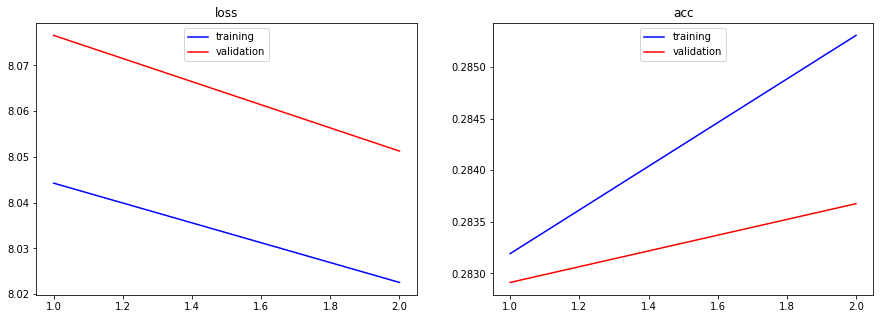

In [21]:
plot_acc_loss(train_acc, train_loss, valid_acc, valid_loss, epochs=2)

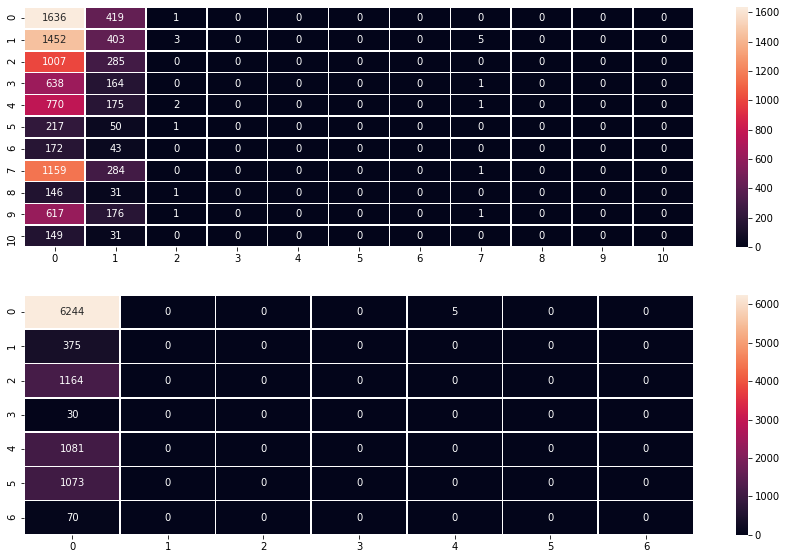

In [22]:
plot_final_confusion_matrices(validation_df, predictions)

In [ ]:
#     train_validation_df = shuffle(train_validation_df)
    #     cut = int(len(train_validation_df)*0.8)
    #     train_df, validation_df = np.split(train_validation_df, [cut], axis=0)

In [ ]:
#                 predictions.append([
#                     outputs1.argmax(1).item(),
#                     outputs2.argmax(1).item(),
#                     outputs3.argmax(1).item()
#                ])

    #     predictions_df = pd.DataFrame(predictions, 
    #           columns= ["grapheme_root", "vowel_diacritic", "consonant_diacritic"])

    #     cnf_matrix_grapheme_root = metrics.confusion_matrix(
    #         np.array(validation_df["grapheme_root"]), np.array(predictions_df["grapheme_root"]))

    #     sn.heatmap(cnf_matrix_grapheme_root, annot=True)

    #     cnf_matrix_vowel_diacritic = metrics.confusion_matrix(
    #         np.array(validation_df["vowel_diacritic"]), np.array(predictions_df["vowel_diacritic"]))

    #     sn.heatmap(cnf_matrix_vowel_diacritic, annot=True)

    #     cnf_matrix_consonant_diacritic = metrics.confusion_matrix(
    #         np.array(validation_df["consonant_diacritic"]), np.array(predictions_df["consonant_diacritic"]))

    #     sn.heatmap(cnf_matrix_consonant_diacritic, annot=True)